In [1]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Embedding, Reshape, Concatenate, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Concatenate
from keras.models import Model
import keras
import gc 
import psutil
from numpy.random import shuffle as sf

2022-05-14 12:25:28.681997: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-14 12:25:28.682068: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
seed_value= 10

import os
os.environ['PYTHONHASHSEED']=str(seed_value)

import random
random.seed(seed_value)

import numpy as np
np.random.seed(seed_value)

import tensorflow as tf
tf.random.set_seed(seed_value)# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

2022-05-14 12:25:30.598602: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-14 12:25:30.599199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-14 12:25:30.599235: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-14 12:25:30.599263: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter): /proc/driver/nvidia/version does not exist


In [3]:
!cat /proc/meminfo | grep Mem

MemTotal:       263916452 kB
MemFree:        208124572 kB
MemAvailable:   211201720 kB


In [4]:
#make the prediction task a supervised problem by creating sequences
def splitSequence(seq, n_steps):
    X = []
    y = []
    for i in range(len(seq)):
        lastIndex = i + n_steps
        if lastIndex > len(seq) - 1:
            break
        seq_X, seq_y = seq[i:lastIndex], seq[lastIndex, -1]
        X.append(seq_X)
        y.append(seq_y)        
    X = np.array(X)
    y = np.array(y)
    return X, y.reshape((len(y), 1))

#split the data into different the users so that we can create on sequence per user but put them again together
def split_df(df, df_batch_size, step_size):
    j = 0
    y_lst = []
    X_lst = []
    for i in df_batch_size: 
        X_seq, y_seq = splitSequence(df.values[j:(i+j)], step_size)
        j += i
        y_seq = y_seq[:X_seq.shape[0], :]
        y_lst.append(y_seq)
        X_lst.append(X_seq)
    return X_lst, y_lst

#creates dummy variable for target
def prepare_targets(y_train, y_valid, y_test):
    le=MultiLabelBinarizer()
    le.fit(y_train)
    y_train_enc = le.transform(y_train)
    y_valid_enc = le.transform(y_valid)
    y_test_enc = le.transform(y_test)
    return y_train_enc, y_valid_enc, y_test_enc

#encode categorical features into numbers 
def encoding_features (X, step_size, unique):
    encoders = {}  
    for i in range(X.shape[2]): 
        le = LabelEncoder()
        le.fit(unique[i].astype(str))# use dataframe here
        encoders[i] = le
        enc = le.transform(X[:, :, i].flatten())
        if i == 0: 
            beg = enc.reshape((X[:, :, i].shape[0], step_size, 1))
        else: 
            beg = np.concatenate([beg, enc.reshape((X[:, :, i].shape[0], step_size, 1))], axis = 2)
    return beg, encoders 

#transfroms categorical features in such a way that they can be handeled by the embeddings layer impöementation 
def emd_input(X):
    X_array = []  
    for i in range(X.shape[2]):  
        if i == X.shape[2]: 
            X_array.append(X[:, :, i+1:i+2])
        else: 
            X_array.append(X[:, :, i:i+1])
    return X_array

#shuffle dataset
def shuffle_list(*ls):
    l =list(zip(*ls))
    sf(l)
    return zip(*l)

In [5]:
#load data
train = pd.read_csv('cleaned_data/model_training_MQ&RQ1/training_data_each_user_batch256_steps20.csv')
train = train.drop(train.columns[0], axis = 1)

valid = pd.read_csv('cleaned_data/model_training_MQ&RQ1/validation_data_each_user_batch256_steps20.csv')
valid = valid.drop(valid.columns[0], axis = 1)

test = pd.read_csv('cleaned_data/model_training_MQ&RQ1/testing_data_each_user_batch256_steps20.csv')
test = test.drop(test.columns[0], axis = 1)

batches =  pd.read_csv('cleaned_data/model_training_MQ&RQ1/batch_size_each_user_batch256_steps20.csv')
batches = batches.drop(batches.columns[0], axis = 1)

In [6]:
#select feature subset
train = train[['EthicaID', 'use_duration', 'duration_ongoing_session', 'time_to_next_app',
               'notification', 'battery','hours', 'weekday', 'category', 'age_category', 'sex',
               'location_cluster', 'geohash', 'target']]
test = test[['EthicaID', 'use_duration', 'duration_ongoing_session', 'time_to_next_app',
               'notification', 'battery','hours', 'weekday', 'category', 'age_category', 'sex',
               'location_cluster', 'geohash', 'target']]
valid = valid[['EthicaID', 'use_duration', 'duration_ongoing_session', 'time_to_next_app',
               'notification', 'battery','hours', 'weekday', 'category', 'age_category', 'sex',
               'location_cluster', 'geohash', 'target']]

In [7]:
full = pd.concat([train, test, valid], axis = 0)
full_cat = full[['notification', 'battery','hours', 'weekday', 'category', 'age_category', 'sex',
       'location_cluster', 'geohash', 'target']]

In [8]:
unique = []
for i in full_cat.columns:
    unique.append(np.unique(full_cat[i].astype(str)))
del full_cat, full

In [9]:
#define hyperparameters
number_num = 3
num_cat = 10
steps = 20
batch_size = 256

In [10]:
#make sequential split of the datasets
X_train_seq, y_train_seq = split_df(train, batches['train'], steps)
X_valid_seq, y_valid_seq = split_df(valid, batches['validation'], steps)
X_test_seq, y_test_seq = split_df(test, batches['testing'], steps)
del train, valid, test

In [11]:
#seperate categorical and numerical features and stack them
X_train_full_seq = np.vstack(X_train_seq)
y_train_full_seq =np.vstack(y_train_seq)
X_train_seq_cat = X_train_full_seq[:, :, number_num+1:].astype(str)
X_train_seq_num = X_train_full_seq[:, :, :number_num+1]#.astype(float)
del X_train_seq, y_train_seq, X_train_full_seq

X_valid_full_seq = np.vstack(X_valid_seq)
y_valid_full_seq =np.vstack(y_valid_seq)
X_valid_seq_cat = X_valid_full_seq[:, :, number_num+1:].astype(str)
X_valid_seq_num = X_valid_full_seq[:, :, :number_num+1]#.astype(float)
del X_valid_seq, y_valid_seq, X_valid_full_seq

X_test_full_seq = np.vstack(X_test_seq)
y_test_full_seq =np.vstack(y_test_seq)
X_test_seq_cat = X_test_full_seq[:, :, number_num+1:].astype(str)
X_test_seq_num = X_test_full_seq[:, :, :number_num+1]#.astype(float)
del X_test_seq, y_test_seq, X_test_full_seq

In [12]:
#encode taregts
y_train_enc, y_valid_enc, y_test_enc =  prepare_targets(y_train_full_seq, y_valid_full_seq, y_test_full_seq)
del y_train_full_seq, y_valid_full_seq, y_test_full_seq

In [13]:
#split training sets in batches to allow for shuffeling
X_train_seq_cat_split = np.split(X_train_seq_cat, X_train_seq_cat.shape[0]/batch_size)
X_train_seq_num_split = np.split(X_train_seq_num, X_train_seq_num.shape[0]/batch_size)
y_train_enc_split = np.split(y_train_enc, X_train_seq_num.shape[0]/batch_size)
del X_train_seq_cat, X_train_seq_num, y_train_enc

In [15]:
#shuffle training set and stack it again together
X_train_seq_cat_shuffled, X_train_seq_num_shuffled, y_train_enc_shuffled = shuffle_list(X_train_seq_cat_split, X_train_seq_num_split, y_train_enc_split)
del X_train_seq_cat_split, X_train_seq_num_split, y_train_enc_split
X_train_seq_cat_shuffled = np.vstack(X_train_seq_cat_shuffled)
X_train_seq_num_shuffled = np.vstack(X_train_seq_num_shuffled)
y_train_enc_shuffled = np.vstack(y_train_enc_shuffled)

In [16]:
#encode categorical features to allow for treatment by an embeddings layer
X_train_enc_shuffled, encoders_train = encoding_features (X_train_seq_cat_shuffled, steps, unique)
X_valid_enc, encoders_valid = encoding_features (X_valid_seq_cat, steps, unique)
X_test_enc, encoders_test = encoding_features (X_test_seq_cat, steps, unique)
del X_train_seq_cat_shuffled

In [17]:
#calculate embedinggs size
cat_sizes = [(i, len(u)) for i, u in zip(range(len(unique)), unique)]  
embedding_sizes = [(c+1, min(50, (c + 1) // 2)) for _, c in cat_sizes]  

[(0, 2),
 (1, 101),
 (2, 24),
 (3, 7),
 (4, 32),
 (5, 4),
 (6, 2),
 (7, 8),
 (8, 1963),
 (9, 3)]

In [19]:
#prepare structure of categorical features for embedinggs layer
X_train_cat_shuffled = emd_input(X_train_enc_shuffled)
X_valid_cat= emd_input(X_valid_enc)
X_test_cat = emd_input(X_test_enc)

In [20]:
#define complete model structure 
def fit_model(neurons):
    cat_input = []
    embed_layers = []
    for (c, (in_size, out_size)) in zip(range(num_cat), embedding_sizes):
        i = Input(shape=(steps, 1) ) 
        o = Embedding(in_size, out_size, name=str(c))(i)
        #o = Dropout(0.04)(o)
        o = Reshape(target_shape=(steps, out_size))(o)
        cat_input.append(i)
        embed_layers.append(o)
    embed = Concatenate()(embed_layers)
    numerical_input = Input(shape=(steps, number_num), name = 'numerical_input')
    new = Concatenate()([embed, numerical_input])

    y=LSTM(neurons, activation='sigmoid')(new)
    d = Dropout(0.2)(y)

    main_output = Dense(3, activation='softmax', name='main_output')(d)
    model = Model(inputs=[cat_input, numerical_input], outputs=main_output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 5, restore_best_weights=True)

In [22]:
import matplotlib.pyplot as plt

Epoch 1/50
13903/13903 [==============================] - 2898s 208ms/step - loss: 1.0678 - accuracy: 0.4135 - val_loss: 1.0630 - val_accuracy: 0.4228
Epoch 2/50
13903/13903 [==============================] - 2887s 208ms/step - loss: 1.0615 - accuracy: 0.4217 - val_loss: 1.0605 - val_accuracy: 0.4251
Epoch 3/50
13903/13903 [==============================] - 2883s 207ms/step - loss: 1.0589 - accuracy: 0.4248 - val_loss: 1.0586 - val_accuracy: 0.4263
Epoch 4/50
13903/13903 [==============================] - 2885s 208ms/step - loss: 1.0570 - accuracy: 0.4272 - val_loss: 1.0580 - val_accuracy: 0.4287
Epoch 5/50
13903/13903 [==============================] - 2898s 208ms/step - loss: 1.0554 - accuracy: 0.4294 - val_loss: 1.0585 - val_accuracy: 0.4262
Epoch 6/50
13903/13903 [==============================] - 2896s 208ms/step - loss: 1.0540 - accuracy: 0.4309 - val_loss: 1.0576 - val_accuracy: 0.4289
Epoch 7/50
13903/13903 [==============================] - 2900s 209ms/step - loss: 1.0527 - ac

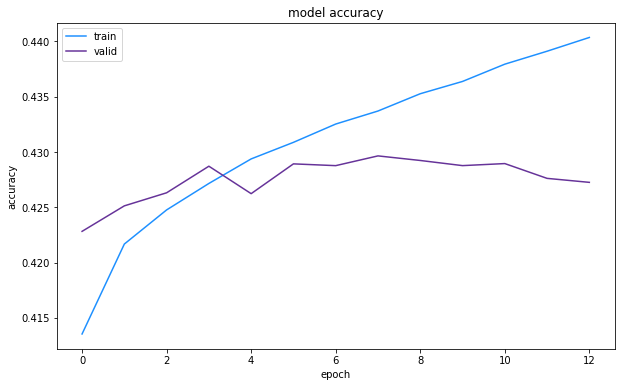

In [23]:
#hyperparemeter opzimization loop
from datetime import datetime
start_time = datetime.now()
for num_neurons in [256]: 
    for batch_size in [256]:
        model = fit_model(num_neurons)
        history = model.fit([X_train_cat_shuffled, X_train_seq_num_shuffled[:, :, 1:].astype(float)], y_train_enc_shuffled, epochs=50, 
                  batch_size = batch_size, 
                  callbacks  = [es], validation_data=([X_valid_cat, X_valid_seq_num[:, :, 1:].astype(float)],
                                                       y_valid_enc))
        _, accuracy = model.evaluate([X_valid_cat, X_valid_seq_num[:, :, 1:].astype(float)], y_valid_enc, verbose=1)
        with open('model/MRQ_full_feature_subset_excl_special_features+Dropout/MRQ_full_feature_subset_excl_special_features+Dropout.txt', 'a') as fp:
            fp.writelines(['Time steps: ' + str(steps) + '\n'+ 'Number of Neurons: ' + str(num_neurons) +
                           '\n', 'Batch Size: ' + str(batch_size) + '\n', 'seed10\n',
                           'Accuracy: ' + str(accuracy) + '\n\n'])
        model.save('model/MRQ_full_feature_subset_excl_special_features+Dropout/model_neurons_'+ str(num_neurons) + 'batch_size' + str(batch_size)
                   + 'time_step' + str(steps) + 'seed10.h5')
        plt.figure(figsize = (10, 6))
        plt.plot(history.history['accuracy'], color = 'dodgerblue')
        plt.plot(history.history['val_accuracy'], color = 'rebeccapurple')
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.xticks(range(0, len(history.history['accuracy'])+1, 2))
        plt.legend(['train', 'valid'], loc='upper left')
        plt.savefig('model/MRQ_full_feature_subset_excl_special_features+Dropout/model_neurons_'+ str(num_neurons) + 'batch_size' + str(batch_size)
                       + 'time_step' + str(steps) + 'seed10.png')
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [24]:
#insert best hyperparameters for calculating final performance
model = keras.models.load_model('model/MRQ_full_feature_subset_excl_special_features+Dropout/model_neurons_256batch_size256time_step20seed10.h5')
_, accuracy_test = model.evaluate([X_test_cat, X_test_seq_num[:, :, 1:].astype(float)], y_test_enc, verbose=1)
print(accuracy_test)

_, accuracy_valid = model.evaluate([X_valid_cat, X_valid_seq_num[:, :, 1:].astype(float)], y_valid_enc, verbose=1)
print(accuracy_valid)

_, accuracy_train = model.evaluate([X_train_cat_shuffled, X_train_seq_num_shuffled[:, :, 1:].astype(float)], y_train_enc_shuffled, verbose=1)
print(accuracy_train)

with open('model/MRQ_full_feature_subset_excl_special_features+Dropout/MRQ_full_feature_subset_excl_special_features+Dropout.txt', 'a') as fp:
    fp.writelines(['Best model accuracy on test set: ' + str(accuracy_test) + '\n\n', 
                   'Best model accuracy on valid set: ' + str(accuracy_valid) + '\n\n', 
                   'Best model accuracy on train set: ' + str(accuracy_train) + '\n\n'])

11800/11800 [==============================] - 191s 16ms/step - loss: 1.0602 - accuracy: 0.4257
0.4256964921951294
14032/14032 [==============================] - 227s 16ms/step - loss: 1.0571 - accuracy: 0.4296
0.42964741587638855
111224/111224 [==============================] - 1915s 17ms/step - loss: 1.0475 - accuracy: 0.4379
0.4378964304924011


In [25]:
#write training time to file
with open('model/MRQ_full_feature_subset_excl_special_features+Dropout/MRQ_full_feature_subset_excl_special_features+Dropout.txt', 'a') as fp:
    fp.writelines(['Time needed for training:', str(end_time - start_time)])